In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from math import *
import time
from numpy import linalg as LA
from sklearn.datasets import fetch_openml
from math import log, exp, ceil, sqrt
from sklearn.model_selection import train_test_split
import warnings
import json
warnings.filterwarnings('ignore', category=UserWarning)

# Setting up functions

In [29]:
"""shuffle and split data to m local training sets and a test set"""
def divide_train_test_among_agents(train_set: pd.DataFrame, num_agents: int) -> list:
    rng = np.random.default_rng(42)
    N, _ = train_set.shape
    split_idx = sorted(rng.choice(N, size = num_agents-1, replace = False))
    return np.split(train_set, split_idx)

def split_train_test(merged_data: pd.DataFrame, train_set_size: int, test_set_size: int, n_agents: int):
    train_df, test_df = train_test_split(merged_data, train_size=train_set_size, test_size=test_set_size)
    shuffled = train_df.sample(frac=1)
    train_sets = divide_train_test_among_agents(shuffled, n_agents)
    for i in range(n_agents):
        train_sets[i].reset_index(drop=True, inplace=True) # reindex each agent set to start from 0
    return train_df, train_sets, test_df

# Laplacian Heuristics to build doubly stochastic matrix, see [[https://web.stanford.edu/~boyd/papers/pdf/fastavg.pdf]]
def is_nonnegative(A: np.ndarray):
    return np.min(A) >= 0

"""
Returns a tuple (a, b, c) of Booleans, where a is True iff A is square, b is True iff A is nonnegative,
and c is True iff AA
"""
def is_doubly_stochastic(A: np.ndarray):
    x,y,z = True, True, True
    m, n = A.shape
    if (m != n):
        x = False
    if not is_nonnegative(A):
        y = False
    z = np.equal(A.sum(0), np.ones(m)).all() and np.equal(A.sum(1), np.ones(n)).all()
    return x,y,z

def assign_weights(A: np.ndarray, **kwargs):
    m, n = A.shape
    if (m != n):
        print("error: matrix provided is not a valid graph")
        return
    L = kwargs.get('L', A @ A.T)
    d_max = np.max(L)
    a_md = 1 / d_max
    W = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            if i == j:
                d_i = L[i,j]
                W[i,j] = 1 - (d_i * a_md)
            elif A[i,j] != 0:
                W[i,j] = a_md
    return W

def ring_graph(v, draw=False):
    seed = 42
    G = nx.cycle_graph(v)
    pos = nx.spring_layout(G, seed=seed)
    if draw:
        nx.draw(G, pos=pos)
        plt.show()
    A = nx.to_numpy_array(G)
    n,n = A.shape
    for i in range(n):
        for j in range(n):
            A[i,j] = -A[i,j]
    W = assign_weights(A)
    return G, W

def complete_graph(v, draw=False):
    if v == 1:
        return nx.complete_graph(1), np.asarray([[1]])
    # use seed for reproducibility
    seed = 42
    G = nx.complete_graph(v)
    pos = nx.spring_layout(G, seed=seed)
    if draw:
        nx.draw(G, pos=pos)
        plt.show()
    A = nx.to_numpy_array(G)
    n, n = A.shape
    for i in range(n):
        for j in range(n):
            A[i,j] = -A[i,j]
    W = assign_weights(A)
    return G, W

def draw_graph(G):
    seed = 42
    pos = nx.circular_layout(G, seed=seed)
    nx.draw(G, pos = pos)
    plt.show()

def F_global(x: np.ndarray, train_sets: list[np.ndarray], n_agents: int):
    return sum(f_local(x, train_sets[i]) for i in range(n_agents)) / n_agents

def f_local(x: np.ndarray, train_set):
    train_set = train_set.to_numpy()
    data, labels = train_set[:, :-1], train_set[:, -1:]     # data is an array size N*784, labels is vector size N*1
    n_labels, n_attributes = data.shape
    x.reshape((n_attributes,1)) # x is a vector size 784*1

    # calculate logit
    ux = data @ x # this should now be N*1
    vux = -np.multiply(labels, ux)
    obj_val = 0
    obj_val = sum([vux[i,0] if vux[i,0] > 709 else log(1 + exp(vux[i, 0])) for i in range(n_labels)]) / n_labels

    output = obj_val
    return output

def sgd_f(x_vec: np.ndarray, train_set, batch_size: int, batch_idx_row: np.ndarray):
    train_set = train_set.to_numpy()
    data, labels = train_set[:, :-1], train_set[:, -1:]
    n_labels, n_attributes = data.shape
    output = np.zeros((n_attributes, 1))
    for r in batch_idx_row:
        i = np.ndarray.item(r) if type(r) == np.ndarray else r
        # must set a cutoff for exp() to avoid floating point error
        output += (-labels[i,0]/(1+exp(min(709,labels[i,0]*np.dot(data[i,:],x_vec))))*data[[i],:]).reshape((n_attributes, 1))
    return output/batch_size

def sgd_WF(X_matrix: np.ndarray, train_sets: list[np.ndarray], batch_size: int, batch_idxs: list):
    m, n = X_matrix.shape
    output = np.zeros((m,n))
    for i in range(m):
        x_vec = X_matrix[i,:].reshape((n,1))
        grad_vec = sgd_f(x_vec, train_sets[i], batch_size, batch_idxs[i])
        output[i,:] = grad_vec.reshape((1,n))
    return output/m

def DSGT(train_sets: list[np.ndarray],
    max_iter: int,
    epoch_size: int,
    X_0: np.ndarray,
    W: np.ndarray,
    initial_step_size: np.ndarray,
    batch_size: int):

    stepsize_rule = lambda x : initial_step_size / (x+1) # stepsize update rule according to equation 10

    m,n = X_0.shape
    f_vals, consensus_err_vals = np.zeros(epoch_size + 1), np.zeros(epoch_size + 1)
    
    X_next = X_0
    batch_idxs_next = [np.random.randint((len(train_sets[i])), size=(batch_size)) for i in range(m)] # create random batches for each agent
    Y_next = sgd_WF(X_next, train_sets, batch_size, batch_idxs_next)
    
    epoch_idx = 0
    for k in range(max_iter + 1):
        # store old X, Y
        X_now = X_next
        Y_now = Y_next
        batch_idxs_now = batch_idxs_next
        
        # update X, Y, stepsize:
        stepsize = stepsize_rule(k)
        X_next = W.dot(X_now - np.dot(stepsize, Y_now))
        batch_idxs_next = [np.random.randint((len(train_sets[i])), size=(batch_size)) for i in range(m)]
        Y_next = W.dot(Y_now) + sgd_WF(X_next, train_sets, batch_size, batch_idxs_next) - sgd_WF(X_now, train_sets, batch_size, batch_idxs_now)
        
        # add to plots
        if max_iter == 0 or (k % ceil(max_iter/epoch_size)) == 0:
            if m == 1:
                x_ave = X_now[0]
            else:
                x_ave = X_now.mean(0)
            f_vals[epoch_idx] = F_global(x_ave, train_sets, m)
            consensus_err_vals[epoch_idx] = LA.norm(X_now - np.dot(np.ones((m,1)), x_ave.reshape(1,n)))
            epoch_idx += 1
    return f_vals, consensus_err_vals

# Importing the MNIST Dataset

In [3]:
mnist = fetch_openml('mnist_784', version=1)

U0, v0 = mnist['data'], mnist['target']

U = U0.astype(np.double)
v = v0.astype(np.uint8)

/usr/lib/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


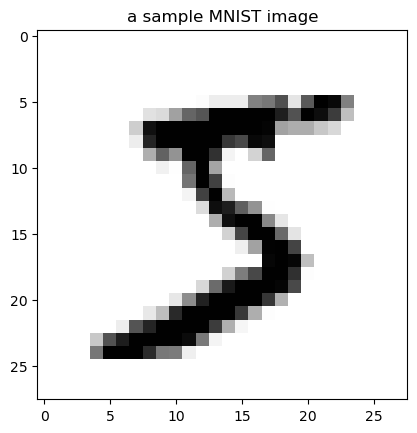

In [4]:
sample_image = U.iloc[0,:].to_numpy().reshape(28,28)
plt.imshow(sample_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.title('a sample MNIST image')
plt.show()

In [5]:
# binary classification on detecting '5', labels {-1, +1}
v_bin_5_lst = [2*int(v[i] == 5)-1 for i in range(len(v))]

In [6]:
# create a single dataframe of attributes + labels

df_U = pd.DataFrame(data=U)
df_v = pd.DataFrame(data=np.asarray(v_bin_5_lst), columns=['label'])
df_data_merged = pd.concat([df_U, df_v.reindex(df_U.index)], axis=1)
df_data_merged.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


# Running DSGT and comparing against a batch SGD method

In [31]:
# implement training
train_set_size,test_set_size,m = 50_000, 10_000,4

data_impl = df_data_merged

n_attributes = len(data_impl.columns)-1
N = train_set_size

"""a dictionary with key:value == name of run : (x_sol, f_vals, consensus_err_vals)"""
all_samplepaths = {}
num_properties = 2

In [32]:
### DSGT ###
m = 4

epoch_size = 10
max_iter = 1000

DSGT_batch_size = 1
constant_step_ctr = 10**-2
init_step_size = constant_step_ctr*np.ones((1,m)) # make initial step size small enough to likely satisfy equation 10

data_impl = df_data_merged

train_set, train_sets, test_set = split_train_test(data_impl, train_set_size, test_set_size, m)

n_attributes = len(data_impl.columns)-1
N = train_set_size

x0_DSGT = np.random.rand(m,n_attributes)
x0_DSGT_copy = x0_DSGT
G_DSGT, W_DSGT = complete_graph(m)

x_ave = x0_DSGT.mean(0)

t1_DSGT = time.time()
f_vals, consensus_err_vals = DSGT(train_sets, max_iter, epoch_size, x0_DSGT, W_DSGT, init_step_size, DSGT_batch_size)
t2_DSGT = time.time()
time_DSGT = t2_DSGT - t1_DSGT

key = "IR-DSGT"
all_samplepaths[key] = f_vals, consensus_err_vals

print(f'{key} with {m} nodes:    f(x_{max_iter}) = {all_samplepaths[key][0][-1]:.3f}         time(sec) = {avg_time_DSGT:.1f}')

IR-DSGT with 4 nodes:    f(x_1000) = 414.926         time(sec) = 159.5


In [34]:
### compare against SGD ###
SGD_batch_size = m * DSGT_batch_size     # match the size of the batch in DSGT across all agents
init_step_size =  constant_step_ctr*np.ones((1,1))

x0_SGD = (x0_DSGT.mean(0)).reshape((1,n_attributes)) # take the average point in the DSGT run as starting of SGD
G_SGD, W_SGD = complete_graph(1)

t1_SGD = time.time()
f_vals, consensus_err_vals = DSGT(train_sets, max_iter, epoch_size, x0_SGD, W_SGD, init_step_size, SGD_batch_size)
t2_SGD = time.time()
time_DSGT = t2_SGD - t1_SGD

key = "batch SGD"
all_samplepaths[key] = f_vals, consensus_err_vals

print(f'{key} with {m} nodes:    f(x_{max_iter}) = {all_samplepaths[key][0][-1]:.3f}         time(sec) = {avg_time_DSGT:.1f}')

batch SGD with 4 nodes:    f(x_1000) = 658.018         time(sec) = 159.5


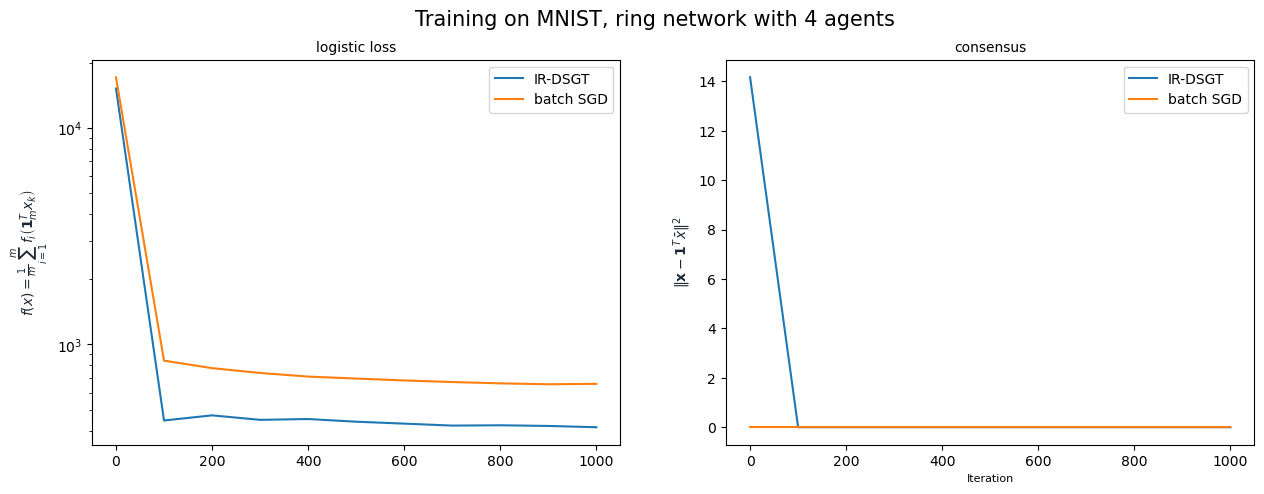

In [39]:
# sample path of 1 run of DSGT
from itertools import cycle

fig = plt.figure(figsize=(15,5))

# f_i plot
plt.subplot(121)
for key in all_samplepaths:
    plt.plot(range(0,max_iter+1,ceil(max_iter/epoch_size)), all_samplepaths[key][0], label=key)
plt.legend(loc=1,fontsize=10)
plt.ylabel(r"$f(x) = \frac{1}{m}\sum_{i=1}^mf_i\left(\mathbf{1}^T_mx_k\right)$", color='#1C2833',fontsize=10)
plt.yscale('log')
plt.title("logistic loss", fontsize=10)

# consensus plot
plt.subplot(122)
for key in all_samplepaths:
    plt.plot(range(0,max_iter+1,ceil(max_iter/epoch_size)), all_samplepaths[key][1], label=key)
plt.legend(loc=1,fontsize=10)
plt.xlabel('Iteration',fontsize=8)
plt.ylabel(r"$\| \mathbf{x} - \mathbf{1}^T\bar{x} \|^2$", color='#1C2833',fontsize=10)
plt.title("consensus", fontsize=10)

plt.suptitle("Training on MNIST, ring network with 4 agents", fontsize=15)
plt.show()